# Machine learning-based framework for prospectivity mapping of critical minerals

### Ehsan Farahbakhsh, Vera Nolte-Wilson, R. Ditmar M&uuml;ller

*EarthByte Group, School of Geosciences, University of Sydney, NSW 2006, Australia*

This notebook enables the user to create a prospectivity map of critical minerals in New South Wales, particularly the Lachlan Orogen. It comprises two main sections; in the first section, the available datasets are visualised, and in the second section, machine learning algorithms are applied to create a prospectivity map.

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import contextily as cx
import geopandas as gpd
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netCDF4 import Dataset
import numpy as np
from numpy import genfromtxt
from osgeo import gdal
from osgeo import osr
import os
import pandas as pd
import pickle
from pulearn import BaggingPuClassifier
import rioxarray as rxr
from shapely.geometry import Point
import shapely.strtree
from skimage import exposure, util
from skimage.feature import graycomatrix, graycoprops
from tqdm.notebook import tqdm
import xarray as xr

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

### Mineral Occurrences

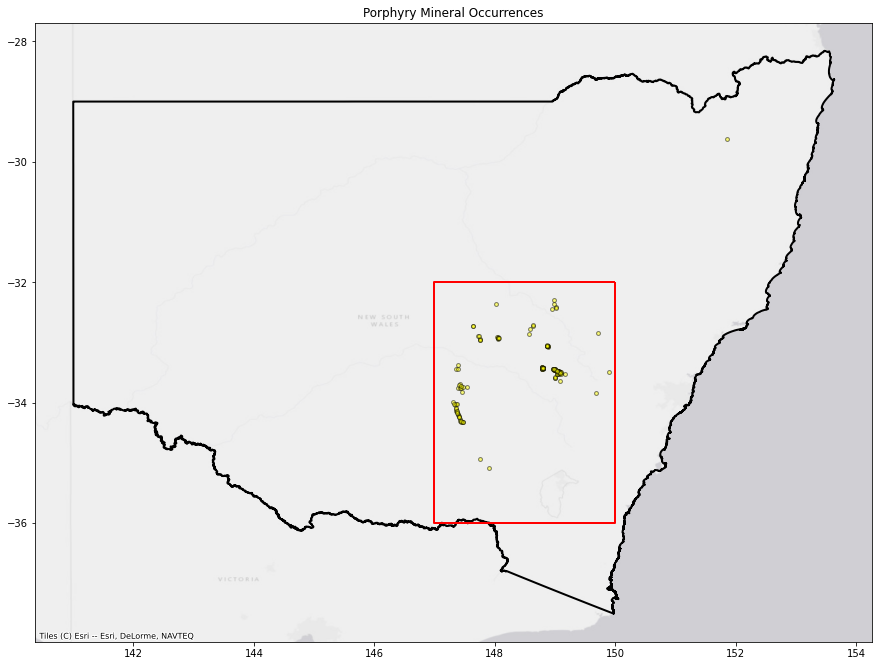

In [2]:
min_occ = gpd.read_file('./Datasets/Mineral Occurrences/GSNSWDataset/porphyry.shp')
nsw_bndy = gpd.read_file('./Datasets/Frames/NSW_Boundary/NSW_STATE_POLYGON_shp_GDA94_NoIsland_ACT.shp')
frame_target = gpd.read_file('./Datasets/Frames/Lachlan_Boundary.shp')

bounds = nsw_bndy.bounds
extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

bounds_target = frame_target.bounds
extent_target = [bounds_target.loc[0]['minx'], bounds_target.loc[0]['maxx'], bounds_target.loc[0]['miny'], bounds_target.loc[0]['maxy']]

fig, ax = plt.subplots(figsize=(15, 15))
min_occ.plot(ax=ax, edgecolor='black', color='yellow', markersize=15, alpha=0.5)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Porphyry Mineral Occurrences')
plt.show()

### Vector Data Layers

#### Intrusion Boundaries

In [3]:
intrusion_bndy_files = [
    './Datasets/Geology/Polylines/IntrusionsBndys_FaultedBndys.shp',
    './Datasets/Geology/Polylines/IntrusionsBndys_GeologicalBndys.shp',
    './Datasets/Geology/Polylines/IntrusionsBndys_IntrusiveBndys.shp',
    './Datasets/Geology/Polylines/IntrusionsBndys_UnconformableBndys.shp'
]

@interact(dataset=intrusion_bndy_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, edgecolor='black', color='yellow', markersize=15, alpha=0.7)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Intrusion Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polylines/IntrusionsBndys_F…

#### Metamorphic Boundaries

In [4]:
metamorphic_bndy_files = [
    './Datasets/Geology/Polylines/MetamorphicBoundaries_Faults.shp',
    './Datasets/Geology/Polylines/MetamorphicBoundaries_GeologicalBndys.shp',
    './Datasets/Geology/Polylines/MetamorphicBoundaries_MetamorphicBndys.shp',
    './Datasets/Geology/Polylines/MetamorphicBoundaries_Unconformities.shp'
]

@interact(dataset=metamorphic_bndy_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, edgecolor='black', color='yellow', markersize=15, alpha=0.7)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Metamorphic Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polylines/MetamorphicBounda…

#### Metamorphic Isograds

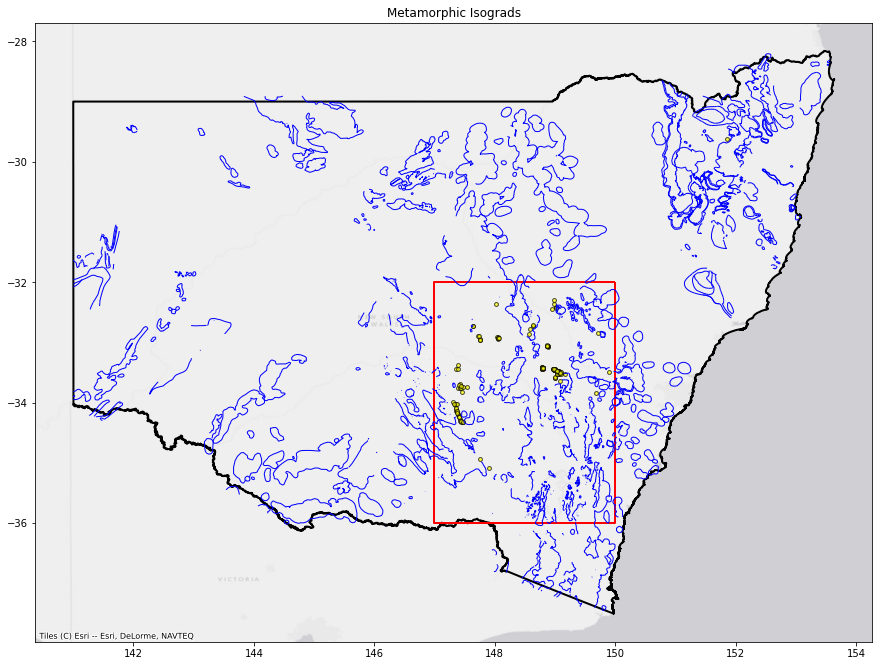

In [5]:
metamorphic_iso_file = './Datasets/Geology/Polylines/MetamorphicIsograds.shp'
metamorphic_iso = gpd.read_file(metamorphic_iso_file)

fig, ax = plt.subplots(figsize=(15, 15))
metamorphic_iso.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, edgecolor='black', color='yellow', markersize=15, alpha=0.7)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Metamorphic Isograds')
plt.show()

#### Rock Units, Boundaries, and Fault Layers

In [6]:
bndy_files = [
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Faulted boundary.shp',
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Geological boundary.shp',
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Intrusive boundary.shp',
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Unconformable boundary.shp'
]

@interact(dataset=bndy_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, edgecolor='black', color='yellow', markersize=15, alpha=0.7)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polylines/RockUnitBndyFault…

#### Intrusions

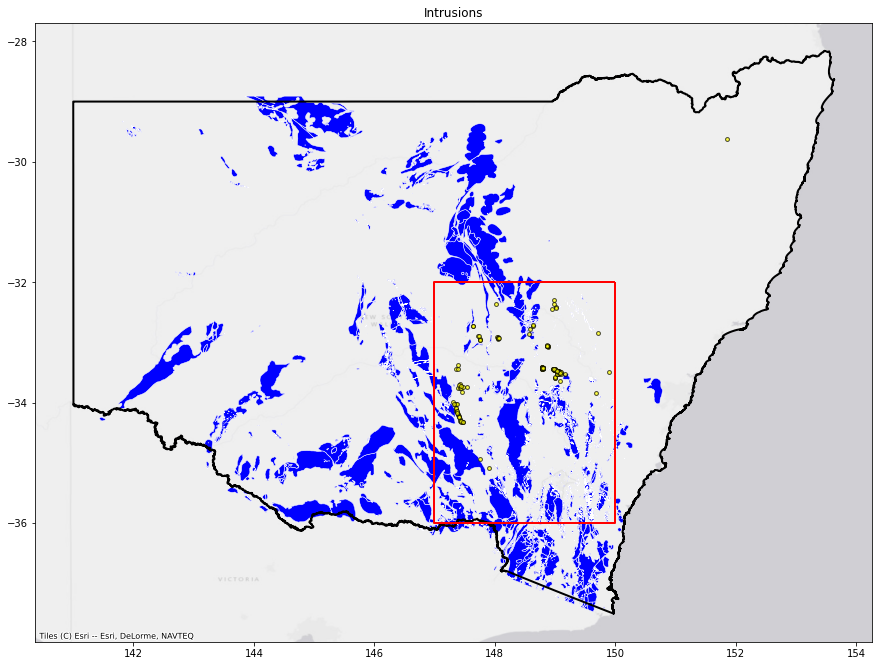

In [7]:
intrusions_file = './Datasets/Geology/Polygons/Intrusions_Tabberabberan.shp'
intrusions = gpd.read_file(intrusions_file)

fig, ax = plt.subplots(figsize=(15, 15))
intrusions.plot(ax=ax, edgecolor='white', color='blue', linewidth=0.5)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, edgecolor='black', color='yellow', markersize=15, alpha=0.7)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Intrusions')
plt.show()

#### Metamorphic Facies

In [8]:
meta_fac_files = [
    './Datasets/Geology/Polygons/MetamorphicFacies_Benambran.shp',
    './Datasets/Geology/Polygons/MetamorphicFacies_KanimblanTablelands.shp',
    './Datasets/Geology/Polygons/MetamorphicFacies_Tabberabberan.shp'
]

@interact(dataset=meta_fac_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='white', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, edgecolor='black', color='yellow', markersize=15, alpha=0.7)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Intrusion Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polygons/MetamorphicFacies_…

#### Rock Units

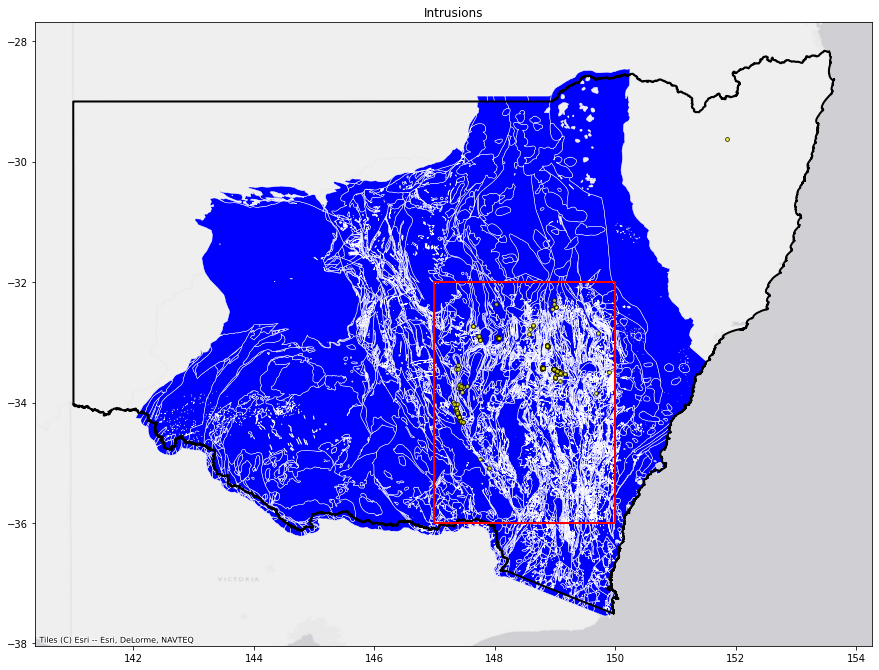

In [9]:
rock_units_file = './Datasets/Geology/Polygons/RockUnits_LAO.shp'
rock_units = gpd.read_file(rock_units_file)

fig, ax = plt.subplots(figsize=(15, 15))
rock_units.plot(ax=ax, edgecolor='white', color='blue', linewidth=0.5)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, edgecolor='black', color='yellow', markersize=15, alpha=0.7)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Intrusions')
plt.show()

### Raster Data Layers

#### Magnetic Grids

In [10]:
magnetic_files = [
    './Datasets/Magnetic/Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_05vd-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_as-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-Bzz-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-PGrav-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-PGravTHD-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-Phase-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-PSusp-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC0m500mRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC1km2kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC2km4kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC4km8kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC8km12kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC12km16kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC16km20kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC24km30kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC36km42kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC42km50kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi-Cellsize40m-AWAGS_MAG_2019.tif'
    ]

@interact(file=magnetic_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    # reproject if required
    if raster.rio.crs.to_epsg() != nsw_bndy.crs.to_epsg():
        raster = raster.rio.reproject(nsw_bndy.crs)
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Magnetic/Magmap2019-grid-tmi_1vd-AWAGS…

#### Gravity

In [11]:
gravity_files = [
    './Datasets/Gravity/Gravmap2016-grid-grv_cscba.tif',
    './Datasets/Gravity/Gravmap2016-grid-grv_ir.tif',
    './Datasets/Gravity/Gravmap2016-grid-grv_scba.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_1vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_1vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_05vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_05vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_tilt.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_tilt-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_1vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_1vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_05vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_05vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_tilt.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_tilt-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_fa.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_fa-IncludesAirborne.tif'
    ]

@interact(file=gravity_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    # reproject if required
    if raster.rio.crs.to_epsg() != nsw_bndy.crs.to_epsg():
        raster = raster.rio.reproject(nsw_bndy.crs)
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Gravity/Gravmap2016-grid-grv_cscba.tif…

#### Radiometric

In [12]:
radiometric_files = [
    './Datasets/Radiometric/Radmap2019-grid-dose_terr-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-dose_terr-Filtered-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-k_conc-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-k_conc-Filtered-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-th_conc-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-th_conc-Filtered-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-thk_ratio-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-u_conc-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-u_conc-Filtered-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-u2th_ratio-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-uk_ratio-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-uth_ratio-AWAGS_RAD_2019.tif'
    ]

@interact(file=radiometric_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    # reproject if required
    if raster.rio.crs.to_epsg() != nsw_bndy.crs.to_epsg():
        raster = raster.rio.reproject(nsw_bndy.crs)
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Radiometric/Radmap2019-grid-dose_terr-…

#### Remote Sensing

In [13]:
remote_sensing_files = [
    './Datasets/Remote Sensing/AlOH_Group_Composition.tif',
    './Datasets/Remote Sensing/AlOH_Group_Content.tif',
    './Datasets/Remote Sensing/FeOH_Group_Content.tif',
    './Datasets/Remote Sensing/Ferric_Oxide_Composition.tif',
    './Datasets/Remote Sensing/Ferric_Oxide_Content.tif',
    './Datasets/Remote Sensing/Ferrous_Iron_Content_in_MgOH.tif',
    './Datasets/Remote Sensing/Ferrous_Iron_Index.tif',
    './Datasets/Remote Sensing/Green_Vegetation.tif',
    './Datasets/Remote Sensing/Gypsum_Index.tif',
    './Datasets/Remote Sensing/Kaolin_Group_Index.tif',
    './Datasets/Remote Sensing/MgOH_Group_Composition.tif',
    './Datasets/Remote Sensing/MgOH_Group_Content.tif',
    './Datasets/Remote Sensing/Opaque_Index.tif',
    './Datasets/Remote Sensing/Quartz_Index.tif',
    './Datasets/Remote Sensing/Silica_Index.tif'
    ]

@interact(file=remote_sensing_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    # reproject if required
    if raster.rio.crs.to_epsg() != nsw_bndy.crs.to_epsg():
        raster = raster.rio.reproject(nsw_bndy.crs)
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Remote Sensing/AlOH_Group_Composition.…

#### Elevation

In [14]:
elevation_files = [
    './Datasets/Elevation/Gravmap2019-grid-ausdrape_ellips.tif',
    './Datasets/Elevation/Gravmap2019-grid-ausdrape_geoid.tif',
    './Datasets/Elevation/Gravmap2019-grid-dem_ellips.tif',
    './Datasets/Elevation/Gravmap2019-grid-dem_geoid.tif',
    ]

@interact(file=elevation_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    # reproject if required
    if raster.rio.crs.to_epsg() != nsw_bndy.crs.to_epsg():
        raster = raster.rio.reproject(nsw_bndy.crs)
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Elevation/Gravmap2019-grid-ausdrape_el…

### Extract the Coordinates of Mineral Occurrences

In [15]:
# export the coordinates to a CSV file
deposit_coords_file = './Datasets/Outputs/training_data_deposit_coords.csv'

if os.path.isfile(deposit_coords_file):
    print('The coordinates of deposits already exist.')
    deposit_coords = pd.read_csv(deposit_coords_file, index_col=False)
    deposit_num = int(deposit_coords.shape[0])
    deposit_x = pd.Series.tolist(deposit_coords['X'])
    deposit_y = pd.Series.tolist(deposit_coords['Y'])
else:
    deposit_x = min_occ.geometry.x
    deposit_y = min_occ.geometry.y
    deposit_num = min_occ.shape[0]
    deposit_coords = pd.DataFrame(deposit_x, columns=['X'])
    deposit_coords['Y'] = deposit_y
    
    size_code = pd.Series.tolist(min_occ['SIZE_CODE'])
    sample_weight = []
    for i in range(len(size_code)):
        if size_code[i] == 'VLG':
            sample_weight.append(0.5)
        elif size_code[i] == 'LGE':
            sample_weight.append(0.4)
        elif size_code[i] == 'MED':
            sample_weight.append(0.3)
        elif size_code[i] == 'SML':
            sample_weight.append(0.2)
        elif size_code[i] == 'OCC':
            sample_weight.append(0.1)
        
    deposit_coords['label'] = 1
    deposit_coords['sample_weight'] = sample_weight
    deposit_coords.to_csv(deposit_coords_file, index=False)
    print(f'The coordinates of deposits have been saved to {deposit_coords_file}.')

The coordinates of deposits already exist.


### Prepare the Training Data File

#### Vector Data Layers

##### Polylines

In [16]:
# calculate the distance from points to linear features
def get_dist_lines(xs, ys, lines, column_names):
    # construct a spatial tree considering the geometries of all lines
    dist_to_lines = []
    
    for line in lines:
        line_tree = shapely.strtree.STRtree(line.geometry)
        points = [Point(x, y) for x, y in zip(xs, ys)]
        dist_to_line = []
    
        for p in points:
            dist_to_line.append(p.distance(line_tree.nearest(p))) # shapely v1.8
            # dist_to_line.append(p.distance(line.geometry.iloc[line_tree.nearest(p)])) # shapely v2.0
        
        dist_to_lines.append(dist_to_line)
    
    return pd.DataFrame(np.array(dist_to_lines).T, columns=column_names)

# concatenate and export the features generated using the functions above
def get_vector_data(xs, ys):
    lines_files = intrusion_bndy_files + metamorphic_bndy_files + bndy_files
    lines_files.append(metamorphic_iso_file)
    lines = []
    column_names = []
    
    for file in lines_files:
        lines.append(gpd.read_file(file))
        column_names.append(os.path.splitext(os.path.basename(file))[0])
    
    dist_lines_df = get_dist_lines(xs, ys, lines, column_names)
    return dist_lines_df

deposit_vector_file = f'./Datasets/Outputs/training_data_deposit_vector.csv'

if os.path.isfile(deposit_vector_file):
    print('The vector dataset (deposits) already exists.')
    deposit_vector_data = pd.read_csv(deposit_vector_file, index_col=False)
else:
    deposit_vector_data = get_vector_data(deposit_x, deposit_y)
    deposit_vector_data = deposit_vector_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_vector_data.to_csv(deposit_vector_file, index=False)
    print(f'The vector dataset (deposits) has been saved to {deposit_vector_file}.')

The vector dataset (deposits) already exists.


##### Polygons

In [17]:
# extract categorical data
def get_cat_data(xs, ys):
    polygons_files = meta_fac_files.copy()
    polygons_files.append(intrusions_file)
    polygons_files.append(rock_units_file)
    
    points = [Point(x, y) for x, y in zip(xs, ys)]
    cat_code =  pd.DataFrame()
    
    for file in tqdm(polygons_files):
        column_name = os.path.splitext(os.path.basename(file))[0]
        polygon = gpd.read_file(file)
        temp = []
        for point in points:
            temp_val = 'Null'
            for index, row in polygon.iterrows():
                if point.within(row.geometry):
                    if column_name.startswith('Intrusions') or column_name.startswith('RockUnits'):
                        # temp_val = row.Unit_Name
                        temp_val = row.Dominant_L
                        break
                    elif column_name.startswith('MetamorphicFacies'):
                        temp_val = row.MetFacies
                        break
            temp.append(temp_val)
            
        cat_code[column_name] =  temp
        
    return cat_code

# export the features generated using the functions above
deposit_cat_file = f'./Datasets/Outputs/training_data_deposit_categorical.csv'

if os.path.isfile(deposit_cat_file):
    print('The categorical dataset (deposits) already exists.')
    deposit_cat_data = pd.read_csv(deposit_cat_file, index_col=False)
else:
    deposit_cat_data = get_cat_data(deposit_x, deposit_y)
    deposit_cat_data = deposit_cat_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_cat_data.to_csv(deposit_cat_file, index=False)
    print(f'The categorical dataset (deposits) has been saved to {deposit_cat_file}.')

The categorical dataset (deposits) already exists.


#### Grids

In [18]:
# calculate mean and standard deviation in a buffer zone (circle) surrounding each target point
def get_mean_std(xs, ys, raster_np, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    stds = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
            stds.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

            radius_= math.ceil(radius*raster_np.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius_, radius_+1):
                Y = int((radius_*radius_-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_np.shape[1]-1 and yc >= 0 and yc <= raster_np.shape[0]-1:
                        points_circle.append((xc, yc))
            
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_np.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_np[yy, xx]))
            stds.append(np.nanstd(raster_np[yy, xx]))
            
    return means, stds

# calculate dissimilarity and correlation in a window (square) surrounding each target point
def get_diss_corr(xs, ys, raster_np, bounds, patch_size):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    dissimilarity = []
    correlation = []
    
    for point in points:
        x = point.x
        y = point.y
        
        left = max(x-patch_size/2, bounds[0])
        right = min(x+patch_size/2, bounds[2])
        top = min(y+patch_size/2, bounds[3])
        bottom = max(y-patch_size/2, bounds[1])
        
        left_idx = math.floor((left-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        right_idx = math.floor((right-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        bottom_idx = math.floor((bottom-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))
        top_idx = math.floor((top-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

        xs = np.arange(left_idx, right_idx+1)
        ys = np.arange(raster_np.shape[0]-1-top_idx, raster_np.shape[0]-1-bottom_idx+1)
        xm, ym = np.meshgrid(xs, ys)
        
        if np.isnan(raster_np[ym, xm]).all():
            dissimilarity.append(np.nan)
            correlation.append(np.nan)
        else:
            raster_scaled = exposure.rescale_intensity(raster_np[ym, xm], in_range=(np.nanmin(raster_np[ym, xm]), np.nanmax(raster_np[ym, xm])), out_range=(0, 1))
            raster_ubyte = util.img_as_ubyte(raster_scaled)
            glcm = graycomatrix(raster_ubyte, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
            dissimilarity.append(graycoprops(glcm, 'dissimilarity')[0, 0])
            correlation.append(graycoprops(glcm, 'correlation')[0, 0])
    
    return dissimilarity, correlation

# concatenate and export the features generated from the functions above
def get_grid_data(xs, ys, grid_filenames):
    grid_features = []
    grid_column_names = []

    for grid in tqdm(grid_filenames):
        prefix = os.path.splitext(os.path.basename(grid))[0]
        grid_column_names.append(prefix+'_mean')
        grid_column_names.append(prefix+'_std')
        grid_column_names.append(prefix+'_dissimilarity')
        grid_column_names.append(prefix+'_correlation')

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        
        # reproject if required
        if raster.rio.crs != nsw_bndy.crs:
            raster = raster.rio.reproject(nsw_bndy.crs)

        bounds = (raster.rio.bounds())
        raster_np = raster.values
        
        means, stds = get_mean_std(xs, ys, raster_np, bounds, 0.1) # search radius = 0.1
        grid_features.append(means)
        grid_features.append(stds)

        dissimilarity,  correlation = get_diss_corr(xs, ys, raster_np, bounds, 0.2) # side of square = 0.2
        grid_features.append(dissimilarity)
        grid_features.append(correlation)
        
        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

grid_filenames = magnetic_files + gravity_files + radiometric_files + remote_sensing_files

deposit_grid_file = './Datasets/Outputs/training_data_deposit_grids.csv'

if os.path.isfile(deposit_grid_file):
    print('The grid dataset (deposits) already exists.')
    deposit_grid_data = pd.read_csv(deposit_grid_file, index_col=False)
else:
    deposit_grid_data = get_grid_data(deposit_x, deposit_y, grid_filenames)
    deposit_grid_data = deposit_grid_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_grid_data.to_csv(deposit_grid_file, index=False)
    print(f'The grid dataset (deposits) has been saved to {deposit_grid_file}.')

The grid dataset (deposits) already exists.


In [19]:
# calculate mean in a buffer zone (circle) surrounding each target point
def get_mean(xs, ys, raster_grad, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_grad.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_grad.shape[0]-1))

            radius_ = math.ceil(radius*raster_grad.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius_, radius_+1):
                Y = int((radius_*radius_-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_grad.shape[1]-1 and yc >= 0 and yc <= raster_grad.shape[0]-1:
                        points_circle.append((xc, yc))
                    
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_grad.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_grad[yy, xx]))
            
    return means

# calculate gradient
def get_gradient_data(xs, ys, elevation_files):
    grid_features = []
    grid_column_names = []

    for grid in tqdm(elevation_files):
        prefix = os.path.splitext(os.path.basename(grid))[0]
        grid_column_names.append(prefix+'_dx')
        grid_column_names.append(prefix+'_dy')

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        
        # reproject if required
        if raster.rio.crs != nsw_bndy.crs:
            raster = raster.rio.reproject(nsw_bndy.crs)

        bounds = (raster.rio.bounds())
        raster_np = np.array(raster)
        raster_grad_x = np.gradient(raster_np)[1]
        raster_grad_y = np.gradient(raster_np)[0]
        
        means_x = get_mean(xs, ys, raster_grad_x, bounds, 0.1)
        means_y = get_mean(xs, ys, raster_grad_y, bounds, 0.1)
        grid_features.append(means_x)
        grid_features.append(means_y)

        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

deposit_elev_file = f'./Datasets/Outputs/training_data_deposit_elevation.csv'

if os.path.isfile(deposit_elev_file):
    print('The elevation dataset (deposits) already exists.')
    deposit_elev_data = pd.read_csv(deposit_elev_file, index_col=False)
else:    
    deposit_elev_data = get_gradient_data(deposit_x, deposit_y, elevation_files)
    deposit_elev_data = deposit_elev_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_elev_data.to_csv(deposit_elev_file, index=False)
    print(f'The elevation dataset (deposits) has been saved to {deposit_elev_file}.')

The elevation dataset (deposits) already exists.


#### Create the Training Data File of Mineral Occurrences

In [20]:
# concatenate all the features generated using the coordinates of the mineral occurrences (positive samples)
deposit_training_data_file = f'./Datasets/Outputs/training_data_deposit.csv'

if os.path.isfile(deposit_training_data_file):
    print('The training data file (deposits) already exists.')
    deposit_training_data = pd.read_csv(deposit_training_data_file, index_col=False)    
    deposit_training_data_columns = deposit_training_data.columns.tolist()
    deposit_num_data_columns = []
    deposit_cat_data_columns = []

    for column in deposit_training_data_columns:
        if column.startswith('Intrusions_') or column.startswith('MetamorphicFacies') or column.startswith('RockUnits'):
            deposit_cat_data_columns.append(column)
        else:
            deposit_num_data_columns.append(column)
    
    deposit_num_data_columns = [e for e in deposit_num_data_columns if e not in ('label', 'sample_weight')]
    deposit_num_data = deposit_training_data[deposit_num_data_columns]
    deposit_cat_data = deposit_training_data[deposit_cat_data_columns]
else:
    deposit_training_data = pd.concat([
        deposit_coords,
        deposit_grid_data,
        deposit_elev_data,
        deposit_vector_data,
        deposit_cat_data
    ],
        axis=1)
    
    # remove the samples with missing values
    deposit_training_data = deposit_training_data.dropna()

    # separate numerical and categorical features
    deposit_num_data = deposit_training_data[deposit_training_data.columns[4:deposit_training_data.shape[1]-deposit_cat_data.shape[1]]]
    deposit_cat_data = deposit_training_data[deposit_training_data.columns[deposit_training_data.shape[1]-deposit_cat_data.shape[1]:deposit_training_data.shape[1]]]

    unique_columns_num = []
    # romove columns (features) with a unique value from the list of numerical features
    for i in range(deposit_num_data.shape[1]):
        if len(deposit_num_data.iloc[:, i].round(4).unique()) == 1:
            unique_columns_num.append(deposit_num_data.columns[i])

    deposit_num_data.drop(unique_columns_num, axis=1, inplace=True)
    deposit_cat_data_columns = deposit_cat_data.columns.to_list()
    deposit_features = pd.concat([deposit_num_data, deposit_cat_data], axis=1).reset_index(drop=True)
    deposit_labels = deposit_training_data[deposit_training_data.columns[2]].reset_index(drop=True)
    deposit_weights = deposit_training_data[deposit_training_data.columns[3]].reset_index(drop=True)
    deposit_training_data = pd.concat([deposit_labels, deposit_weights, deposit_features], axis=1).reset_index(drop=True)
    deposit_training_data.to_csv(deposit_training_data_file, index=False)
    
    print(f'The training data file (deposits) has been saved to {deposit_training_data_file}.')

The training data file (deposits) already exists.


### Random (Unlabelled) Samples

The coordinates of unlabelled samples already exist.


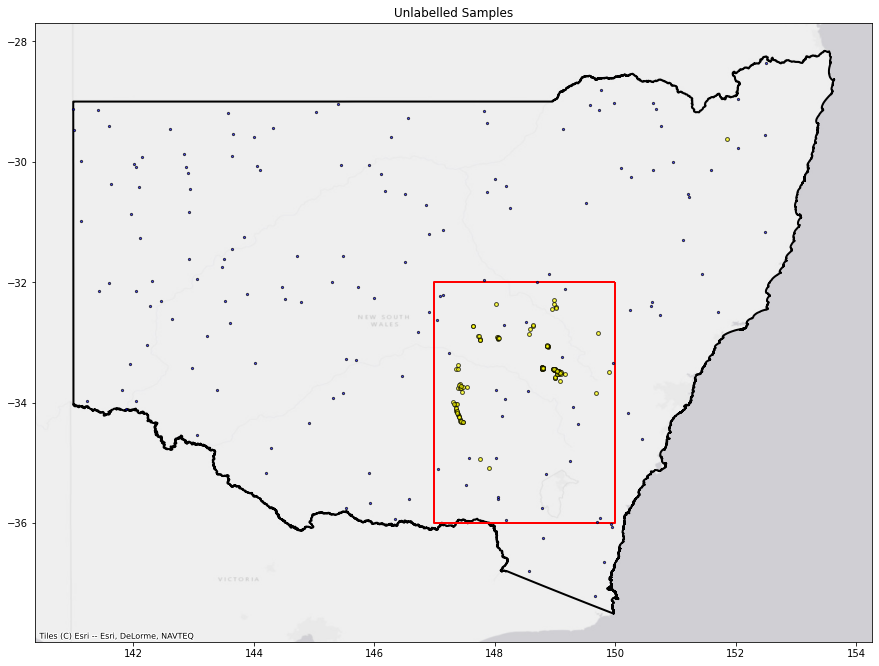

In [21]:
# generate and extract the coordinates of a number of random samples within the desired polygon
def get_unlab_samples(polygon, num_features):
    bounds = polygon.bounds
    
    rand_x = np.random.uniform(low=extent[0], high=extent[1], size=deposit_training_data.shape[0]*2)
    rand_y = np.random.uniform(low=extent[2], high=extent[3], size=deposit_training_data.shape[0]*2)
    
    unlab_x = []
    unlab_y = []

    for x, y in zip(rand_x, rand_y):
        if len(unlab_x) == deposit_training_data.shape[0]:
            break
        p = Point((x, y))
        if p.within(polygon.geometry[0]):
            unlab_x.append(x)
            unlab_y.append(y)
    
    return unlab_x, unlab_y

num_features = deposit_training_data.shape[1] - 1
# export the coordinates of the random samples to a CSV file
unlab_coords_file = './Datasets/Outputs/training_data_unlab_coords.csv'

if os.path.isfile(unlab_coords_file):
    print('The coordinates of unlabelled samples already exist.')
    unlab_coords = pd.read_csv(unlab_coords_file, index_col=False)
    unlab_x = pd.Series.tolist(unlab_coords['X'])
    unlab_y = pd.Series.tolist(unlab_coords['Y'])
else:
    unlab_x, unlab_y = get_unlab_samples(nsw_bndy, num_features)
    unlab_coords = pd.DataFrame(unlab_x, columns=['X'])
    unlab_coords['Y'] = unlab_y
    unlab_label = [0]*len(unlab_x)
    unlab_coords['label'] = unlab_label
    unlab_coords['sample_weight'] = 0.5
    unlab_coords.to_csv(unlab_coords_file, index=False)
    print(f'The coordinates of unlabelled samples have been saved to {unlab_coords_file}.')

# plot unlabelled samples
fig, ax = plt.subplots(figsize=(15, 15))
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
ax.scatter(unlab_x, unlab_y, color='blue', edgecolors='black', s=5, alpha=0.7)
min_occ.plot(ax=ax, edgecolor='black', color='yellow', markersize=15, alpha=0.7)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Unlabelled Samples')
plt.show()

#### Create the Training Data File of Random Samples

In [22]:
unlab_vector_file = './Datasets/Outputs/training_data_unlab_vector.csv'

if os.path.isfile(unlab_vector_file):
    print('The vector dataset (unlabelled samples) already exists.')
    unlab_vector_data = pd.read_csv(unlab_vector_file, index_col=False)
else:
    unlab_vector_data = get_vector_data(unlab_x, unlab_y)
    unlab_vector_data = unlab_vector_data[unlab_vector_data.columns.intersection(unlab_vector_data.columns)]
    unlab_vector_data.to_csv(unlab_vector_file, index=False)
    print(f'The vector dataset (unlabelled samples) has been saved to {unlab_vector_file}.')

unlab_cat_file = './Datasets/Outputs/training_data_unlab_categorical.csv'

if os.path.isfile(unlab_cat_file):
    print('The categorical dataset (unlabelled samples) already exists.')
    unlab_cat_data = pd.read_csv(unlab_cat_file, index_col=False)
else:
    unlab_cat_data = get_cat_data(unlab_x, unlab_y)
    unlab_cat_data = unlab_cat_data[unlab_cat_data.columns.intersection(deposit_cat_data.columns)]
    unlab_cat_data.to_csv(unlab_cat_file, index=False)
    print(f'The categorical dataset (unlabelled samples) has been saved to {unlab_cat_file}.')

unlab_grid_file = './Datasets/Outputs/training_data_unlab_grids.csv'

if os.path.isfile(unlab_grid_file):
    print('The grid dataset (unlabelled samples) already exists.')
    unlab_grid_data = pd.read_csv(unlab_grid_file, index_col=False)
else:
    unlab_grid_data = get_grid_data(unlab_x, unlab_y, grid_filenames)
    unlab_grid_data = unlab_grid_data[unlab_grid_data.columns.intersection(deposit_grid_data.columns)]
    unlab_grid_data.to_csv(unlab_grid_file, index=False)
    print(f'The grid dataset (unlabelled samples) has been saved to {unlab_grid_file}.')
    
unlab_elev_file = './Datasets/Outputs/training_data_unlab_elevation.csv'

if os.path.isfile(unlab_elev_file):
    print('The elevation dataset (unlabelled samples) already exists.')
    unlab_elev_data = pd.read_csv(unlab_elev_file, index_col=False)
else:
    unlab_elev_data = get_gradient_data(unlab_x, unlab_y, elevation_files)
    unlab_elev_data = unlab_elev_data[unlab_elev_data.columns.intersection(deposit_elev_data.columns)]
    unlab_elev_data.to_csv(unlab_elev_file, index=False)
    print(f'The elevation dataset (unlabelled samples) has been saved to {unlab_elev_file}.')

The vector dataset (unlabelled samples) already exists.
The categorical dataset (unlabelled samples) already exists.
The grid dataset (unlabelled samples) already exists.
The elevation dataset (unlabelled samples) already exists.


In [23]:
# concatenate all the features generated in the previous cell
unlab_training_data_file = './Datasets/Outputs/training_data_unlab.csv'

if os.path.isfile(unlab_training_data_file):
    print('The training data file (unlabelled samples) already exists.')
    unlab_training_data = pd.read_csv(unlab_training_data_file, index_col=False)
else:
    unlab_training_data = pd.concat([
        unlab_coords,
        unlab_grid_data,
        unlab_elev_data,
        unlab_vector_data,
        unlab_cat_data],
        axis=1
    )
    
    # remove missing values
    unlab_training_data = unlab_training_data.dropna()
    unlab_training_data = unlab_training_data[unlab_training_data.columns.intersection(deposit_training_data.columns)]
    unlab_training_data.to_csv(unlab_training_data_file, index=False)
    
    print(f'The training data file (unlabelled samples) has been saved to {unlab_training_data_file}.')

Xy_train_original_df_file = './Datasets/Outputs/Xy_train_original.csv'

if os.path.isfile(Xy_train_original_df_file):
    Xy_train_original_df = pd.read_csv(Xy_train_original_df_file, index_col=False)
    print('Features file already exists!')
    
    with open('./Datasets/Outputs/st_scaler.pkl', 'rb') as f:
        st_scaler = pickle.load(f)
        
    with open('./Datasets/Outputs/encoder.pkl', 'rb') as f:
        enc = pickle.load(f)
else:
    deposit_labels = deposit_training_data['label']
    unlab_labels = unlab_training_data['label']
    
    deposit_weights = deposit_training_data['sample_weight']
    unlab_weights = unlab_training_data['sample_weight']
    
    labels = pd.concat([deposit_labels, unlab_labels]).reset_index(drop=True)
    weights = pd.concat([deposit_weights, unlab_weights]).reset_index(drop=True)
    
    training_data_original = pd.concat([deposit_training_data, unlab_training_data]).reset_index(drop=True)
    
    # separate numerical and categorical features
    training_data_num = training_data_original[deposit_num_data.columns]
    training_data_cat = training_data_original[deposit_cat_data.columns]

    # drop highly correlated features
    # create a correlation matrix
    corr_matrix = training_data_num.corr(method='spearman').abs()
    # select the upper triangle of the correlation matrix
    corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # find features with the correlation greater than 0.7
    corr_drop = [column for column in corr_upper.columns if any(corr_upper[column] > 0.7)]
    print('List of the features removed due to high correlation with other features:', corr_drop)
    # drop features
    training_data_num_purged = training_data_num.drop(corr_drop, axis=1)
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(training_data_cat)
    training_data_cat_encoded = enc.transform(training_data_cat).toarray()
    training_data_cat_columns = enc.get_feature_names(training_data_cat.columns).tolist()
    training_data_cat_encoded = pd.DataFrame(training_data_cat_encoded, columns=training_data_cat_columns)
    
    features_labels_encoded = pd.concat([training_data_num_purged, training_data_cat_encoded, weights, labels], axis=1).reset_index(drop=True)
    features_labels_list = features_labels_encoded.columns.tolist()
    features_list = features_labels_list.copy()
    features_list = [e for e in features_list if e not in ('label', 'sample_weight')]

    deposit_data = features_labels_encoded[features_labels_encoded['label']==1]
    unlab_data = features_labels_encoded[features_labels_encoded['label']==0]

    deposit_features = deposit_data[deposit_data.columns[:-1]]
    unlab_features = unlab_data[unlab_data.columns[:-1]]

    deposit_labels = deposit_data[deposit_data.columns[-1]]
    unlab_labels = unlab_data[unlab_data.columns[-1]]

#     deposit_weights = deposit_data[deposit_data.columns[-2]]
#     unlab_weights = unlab_data[unlab_data.columns[-2]]
    
#     deposit_labels_weights = np.vstack((deposit_labels, deposit_weights))
    
    # train test
    # split positive samples into training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(deposit_features, deposit_labels, train_size=0.75, random_state=42)
    X_train = np.vstack((X_train, unlab_features))
    y_train = np.vstack((y_train.values.reshape(-1, 1), unlab_labels.values.reshape(-1, 1)))
    
    Xy_train_original = np.hstack((X_train, y_train))
    Xy_train_original_df = pd.DataFrame(Xy_train_original, columns=features_labels_list)
    Xy_train_original_df.to_csv('./Datasets/Outputs/Xy_train_original.csv', index=False)
    
    X_test_df = pd.DataFrame(X_test, columns=features_list).reset_index(drop=True)
    y_test_df = pd.DataFrame(y_test, columns=['label']).reset_index(drop=True)
    weights_df = pd.DataFrame(X_test, columns=['sample_weight']).reset_index(drop=True)
    
    X_train_num = Xy_train_original_df[training_data_num_purged.columns]
    
    st_scaler = StandardScaler()
    X_train_num = st_scaler.fit_transform(X_train_num)
    X_train_num = pd.DataFrame(X_train_num, columns=training_data_num_purged.columns)
    
    X_test_num = X_test_df[training_data_num_purged.columns]
    X_test_num = st_scaler.transform(X_test_num)
    X_test_num = pd.DataFrame(X_test_num, columns=training_data_num_purged.columns)
    
    Xy_train = pd.concat([X_train_num, Xy_train_original_df[training_data_cat_columns], Xy_train_original_df['sample_weight'], Xy_train_original_df['label']], axis=1).reset_index(drop=True)
    Xy_test = pd.concat([X_test_num, X_test_df[training_data_cat_columns], weights_df, y_test_df], axis=1).reset_index(drop=True)
    
    Xy_train.to_csv('./Datasets/Outputs/Xy_train.csv', index=False)
    Xy_test.to_csv('./Datasets/Outputs/Xy_test.csv', index=False)
    
    # save the standard scaler model
    with open('./Datasets/Outputs/st_scaler.pkl', 'wb') as f:
        pickle.dump(st_scaler, f)
        
    # save the encoder model
    with open('./Datasets/Outputs/encoder.pkl', 'wb') as f:
        pickle.dump(enc, f)

The training data file (unlabelled samples) already exists.
Features file already exists!


### Create the Predictive Model

#### Hyperparameter Tuning

In [24]:
# n_estimators: number of trees in the foreset
# max_features: max number of features considered for splitting a node
# max_depth: max number of levels in each decision tree
# min_samples_split: min number of data points placed in a node before the node is split
# min_samples_leaf: min number of data points allowed in a leaf node
# bootstrap: method for sampling data points (with or without replacement)

if os.path.isfile('./Datasets/Outputs/model.pkl'):
    print('The model already exists!')
    # load the model
    with open('./Datasets/Outputs/model.pkl', 'rb') as f:
        bc_best = pickle.load(f)
else:
    # Random Forest model structure
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    bc = BaggingPuClassifier(rf, n_jobs=-1, random_state=42)

    n_fold = 10

    Xy_train_file = f'./Datasets/Outputs/Xy_train.csv'
    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    features = Xy_train[Xy_train.columns[:-1]]
    labels = Xy_train[Xy_train.columns[-1]]
    X_train_, X_test_, y_train_, y_test_ = train_test_split(features, labels, train_size=0.75, random_state=42)

    sample_weight_train = X_train_[X_train_.columns[-1]]
    X_train_ = X_train_[X_train_.columns[:-1]]
    sample_weight_test = X_test_[X_test_.columns[-1]]
    X_test_ = X_test_[X_test_.columns[:-1]]

    search_space = {
    'base_estimator__bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
    'base_estimator__max_depth': Integer(5, 20), # values of max_depth are integers
    'base_estimator__max_features': Categorical([None, 'sqrt','log2']), 
    'base_estimator__min_samples_leaf': Integer(2, 20),
    'base_estimator__min_samples_split': Integer(2, 30),
    'base_estimator__n_estimators': Integer(10, 200),
    'max_samples': Integer(int(0.5*(len(y_train_)-sum(y_train_))), int(0.9*(len(y_train_)-sum(y_train_))))
    }

    bc_bayes_search = BayesSearchCV(bc, search_space, n_iter=50, # specify how many iterations
                                    scoring='accuracy', n_jobs=-1, cv=n_fold, verbose=1, random_state=42, return_train_score=True)
    bc_bayes_search.fit(X_train_, y_train_, sample_weight=sample_weight_train) # callback=on_step will print score after each iteration

    X_pred = bc_bayes_search.best_estimator_.predict(X_test_)
    X_pred_acc = accuracy_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_pre = precision_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_rec = recall_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_f1 = f1_score(y_test_, X_pred, sample_weight=sample_weight_test)

    bc_best = bc_bayes_search.best_estimator_
    bc_best_acc = bc_bayes_search.best_score_
    print('The highest accuracy during cross validation:', bc_best_acc)
    print('Accuracy:', X_pred_acc)
    print('Precision:', X_pred_pre)
    print('Recall:', X_pred_rec)
    print('F1-Score:', X_pred_f1)
    
    # save the model
    with open('./Datasets/Outputs/model.pkl', 'wb') as f:
        pickle.dump(bc_best, f)
    
    importances = []
    estimators = bc_best.estimators_
    importances = [estimators[j].feature_importances_.reshape(-1, 1) for j in range(len(estimators))]
    importances = np.hstack(importances)

The model already exists!


In [25]:
print(bc_best)

BaggingPuClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                          max_depth=13,
                                                          max_features='sqrt',
                                                          min_samples_leaf=2,
                                                          n_estimators=200,
                                                          n_jobs=-1,
                                                          random_state=42),
                    max_samples=87, n_jobs=-1, random_state=42)


In [26]:
labels_estimated = []
for pair in bc_best.oob_decision_function_:
    if np.isnan(pair[0]) or pair[0] < pair[1]:
        labels_estimated.append(1)
    else:
        labels_estimated.append(0)
        
print('Number of positive samples', labels_estimated.count(1))
print('Number of negative samples', labels_estimated.count(0))

Number of positive samples 93
Number of negative samples 117


In [27]:
Xy_test = pd.read_csv('./Datasets/Outputs/Xy_test.csv', index_col=False)
X_test = Xy_test[Xy_test.columns[:-2]]
y_test = Xy_test[Xy_test.columns[-1]]
sample_weight_test = Xy_test[Xy_test.columns[-2]]
X_pred = bc_best.predict(X_test)
X_pred_acc = accuracy_score(y_test, X_pred, sample_weight=sample_weight_test)
print('Accuracy:', X_pred_acc)

Accuracy: 1.0


#### Feature Importance

In [28]:
features_importance_file = './Datasets/Outputs/features_importance.csv'

if os.path.isfile(features_importance_file):
    features_importance = pd.read_csv(features_importance_file, index_col=False).to_numpy().tolist()
else:
    output_features = Xy_train_original_df.columns.tolist()
    output_features = [e for e in output_features if e not in ('label', 'sample_weight')]
    
    importances_mean = importances.mean(axis=1)
    importances_var = importances.var(axis=1)

    features_importance = [(feature, round(importance, 5)) for feature, importance in zip(output_features, importances_mean)]
    features_importance = sorted(features_importance, key=lambda x:x[1], reverse=True)
    features_importance_df = pd.DataFrame(features_importance, columns=['Feature', 'Importance'])
    features_importance_df['Variance'] = importances_var
    features_importance_df.to_csv(features_importance_file, index=False)

Text(0, 0.5, 'Cumulative Importance')

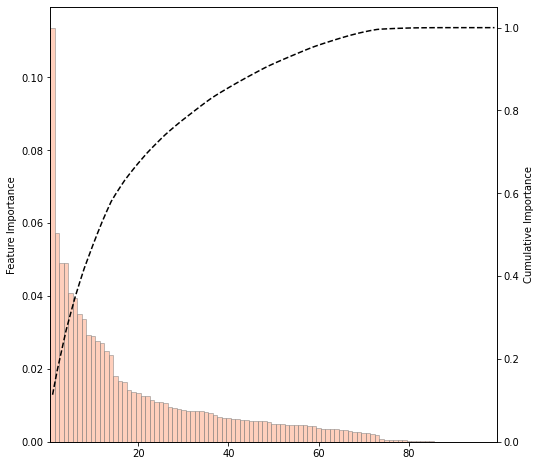

In [29]:
# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in features_importance]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)

x_values = list(range(len(features_importance)))
x_values = [x+1 for x in x_values]

fig = plt.figure(figsize=(8, 8))
ax2 = fig.add_subplot(111)
ax1 = ax2.twinx()

ax2.bar(x_values, sorted_importances, edgecolor='gray', facecolor='LightSalmon', width=1, alpha=0.5)
ax1.plot(x_values, cumulative_importances, 'k--')

plt.xticks(rotation=30)
plt.xlim(0.5, len(cumulative_importances)+0.5)

ax1.set_ylim(0, 1.05)

ax2.set_ylabel('Feature Importance')
ax1.set_ylabel('Cumulative Importance')

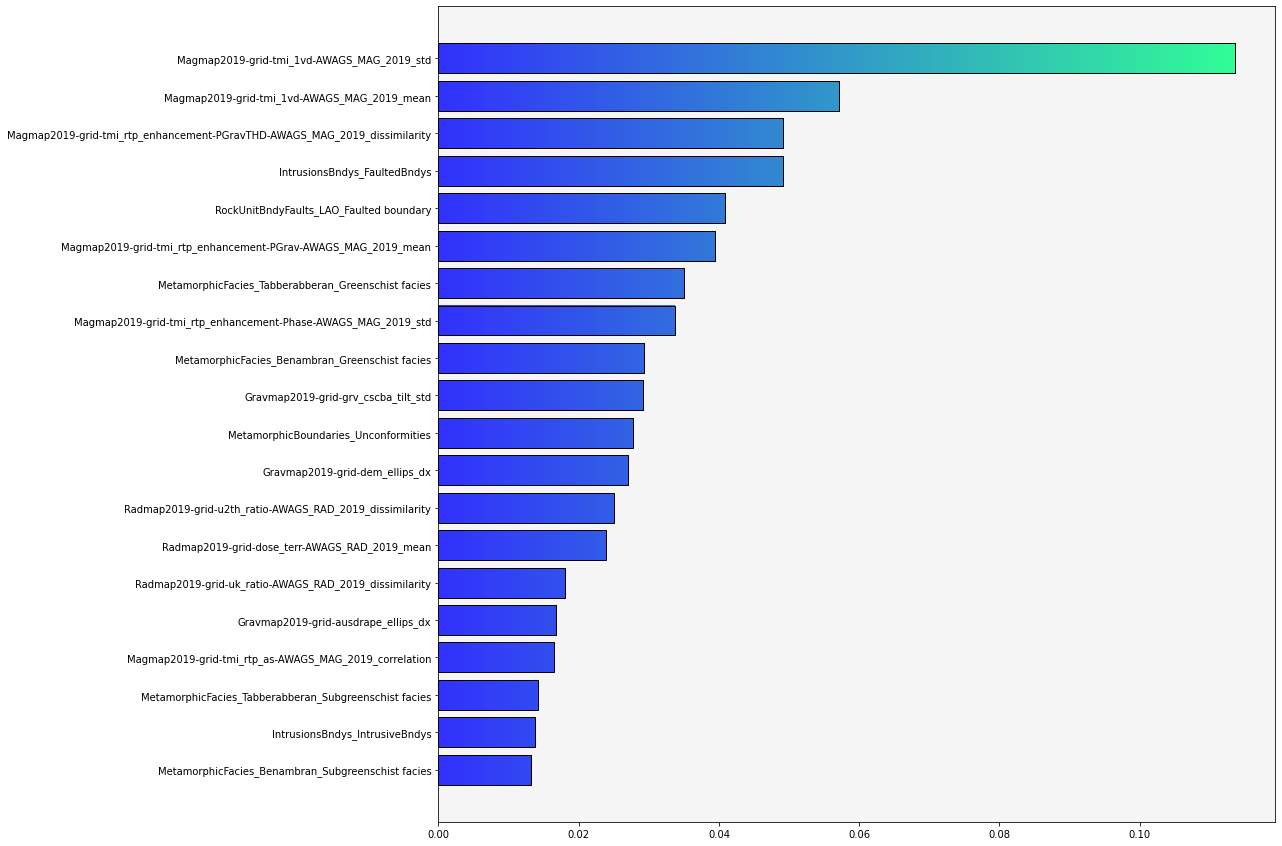

In [30]:
# print significant features above some threshold
features_importance_ = features_importance[:20]
features_importance_.sort(key=lambda x:x[1])
ft_imps = [x[1] for x in features_importance_]

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('whitesmoke')
bar = ax.barh(range(len(ft_imps)), ft_imps)

def gradientbars(bars, data):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        bar.set_edgecolor('black')
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        cmap = plt.get_cmap('winter')
        grad = np.atleast_2d(np.linspace(0, 1*w/max(data), 256))
        ax.imshow(grad, extent=[x, x+w, y, y+h], aspect='auto', zorder=0, norm=mpl.colors.NoNorm(vmin=0, vmax=1), cmap=cmap, alpha=0.8)
        manual_labels = [x[0] for x in features_importance_]
        ax.set_yticks(np.arange(0, len(data), 1).tolist())
        ax.set_yticklabels(manual_labels, minor=False)
    ax.axis(lim)

gradientbars(bar, ft_imps)
plt.gca().yaxis.grid(False)
plt.show()

In [31]:
Xy_train_df = pd.read_csv('./Datasets/Outputs/Xy_train.csv', index_col=False)

@interact
def show_map(feature=Xy_train_df.columns):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    ax1.set_facecolor('whitesmoke')
    ax2 = ax1.twiny()
    
    ax1.hist(Xy_train_original_df[feature], bins=25, alpha=0.0)

    h1 = ax2.hist(Xy_train_df.loc[Xy_train_df['label']==0][feature], bins=25, color='LightSalmon', label='Negative')
    h2 = ax2.hist(Xy_train_df.loc[Xy_train_df['label']==1][feature], bins=25, color='DarkSeaGreen', label='Positive', alpha=0.8)

    ax2.legend()

interactive(children=(Dropdown(description='feature', options=('Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean', …

In [32]:
Xy_train_df_pivot = Xy_train_df.pivot(columns=['label'])
Xy_train_original_df_pivot = Xy_train_original_df.pivot(columns=['label'])

nb_groups1 = Xy_train_df['label'].nunique()
nb_groups2 = Xy_train_original_df['label'].nunique()

@interact
def show_map(feature=Xy_train_df.columns):
    bplot1 = [Xy_train_df_pivot[feature][var].dropna() for var in Xy_train_df_pivot[feature]]
    bplot2 = [Xy_train_original_df_pivot[feature][var].dropna() for var in Xy_train_original_df_pivot[feature]]

    fig, ax1 = plt.subplots(figsize=(8, 8))
    box_param1 = dict(whis=(5, 95), widths=0.2, patch_artist=True,
                      flierprops=dict(marker='.', markeredgecolor='black', fillstyle=None),
                      medianprops=dict(color='black'), boxprops=dict(facecolor='tab:blue'))
    box_param2 = dict(whis=(5, 95), widths=0, patch_artist=True,
                      flierprops=dict(marker='.', markeredgecolor='none', fillstyle=None),
                      medianprops=dict(color='none'), whiskerprops=dict(color='none'),
                      boxprops=dict(facecolor='none', edgecolor='none'))

    ax1.boxplot(bplot1, positions=np.arange(nb_groups1), **box_param1)

    ax2 = ax1.twinx()
    ax2.boxplot(bplot2, positions=np.arange(nb_groups2), **box_param2)

    # format x ticks
    labelsize = 12
    ax1.set_xticks(np.arange(nb_groups1))
    ax1.set_xticklabels(['Negative', 'Positive'])
    ax1.tick_params(axis='x', labelsize=labelsize)

    # format y ticks
    yticks_fmt = dict(axis='y', labelsize=labelsize)

    # format axes labels
    label_fmt = dict(size=12, labelpad=15)
    ax1.set_xlabel(feature, **label_fmt)
    ax1.set_ylabel(feature + '\n(Standardised)', **label_fmt)
    ax2.set_ylabel(feature + '\n(Actual)', **label_fmt)

    plt.show()

interactive(children=(Dropdown(description='feature', options=('Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean', …

### Generate Target Points

The coordinates of target points already exist.
Number of samples:  4661


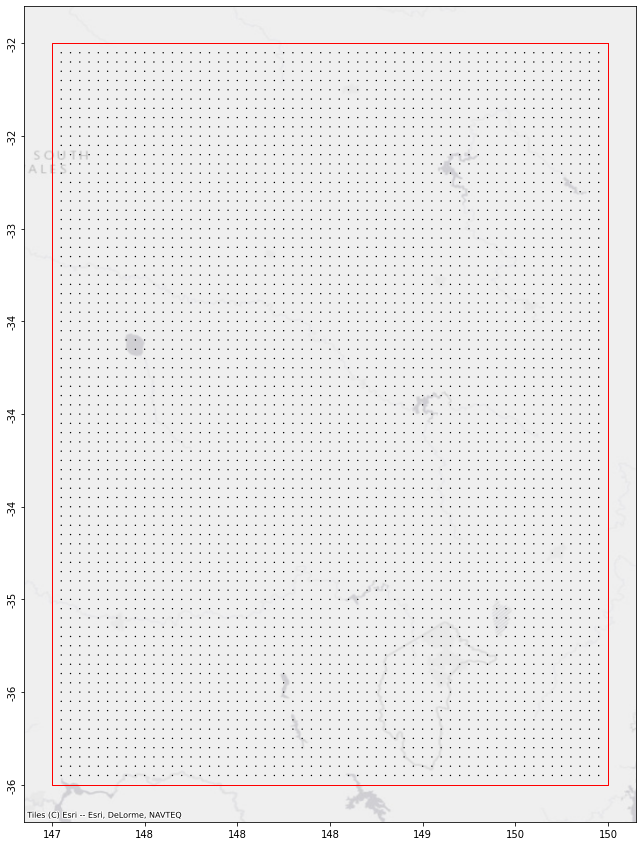

In [33]:
# set the sampling resolution
size_x = 0.05
size_y = 0.05

range_x = np.arange(extent_target[0], extent_target[1], size_x)
range_y = np.arange(extent_target[2], extent_target[3], size_y)

num_x = len(range_x)
num_y = len(range_y)

xs, ys = np.meshgrid(range_x, range_y)

target_coords_file = './Datasets/Outputs/target_coords.csv'
target_mask_file = './Datasets/Outputs/target_mask.csv'

# export the coordinates of the target points and create a mask to keep the points only inside the target polygon boundaries
if os.path.isfile(target_coords_file) and os.path.isfile(target_mask_file):
    print('The coordinates of target points already exist.')
    target_coords = pd.read_csv(target_coords_file, index_col=False)
    target_x = target_coords['X']
    target_y = target_coords['Y']
    target_mask = genfromtxt(target_mask_file, delimiter=',')
else:
    target_x = []
    target_y = []
    target_mask = []
    for xx, yy in zip(xs.flatten(), ys.flatten()):
        p = Point((xx, yy))
        if p.within(frame_target.geometry[0]):
            target_x.append(xx)
            target_y.append(yy)
            target_mask.append(True)
        else:
            target_mask.append(False)
    
    target_coords = pd.DataFrame(target_x, columns=['X'])
    target_coords['Y'] = target_y
    target_coords.to_csv(target_coords_file, index=False)
    
    mask_x = np.array([xs.flatten()]).T
    mask_y = np.array([ys.flatten()]).T
    target_mask_ = np.array([target_mask]).T
    target_mask = np.hstack((mask_x, mask_y, target_mask_))
    np.savetxt(target_mask_file, target_mask, delimiter=',')
    print('The coordinates of target points and mask have been saved.')

print(f'Number of samples: ', len(target_x))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(target_x, target_y, color='black', edgecolors='none', s=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.show()

#### Extract Values of Features at Target Points

In [34]:
target_vector_file = './Datasets/Outputs/target_vector.csv'

if os.path.isfile(target_vector_file):
    print('The vector dataset (target points) already exists.')
    target_vector_data = pd.read_csv(target_vector_file, index_col=False)
else:
    target_vector_data = get_vector_data(target_x, target_y)
    target_vector_data = target_vector_data[target_vector_data.columns.intersection(deposit_vector_data.columns)]
    target_vector_data.to_csv(target_vector_file, index=False)
    print(f'The vector dataset (target points) has been saved to {target_vector_file}.')

target_cat_file = './Datasets/Outputs/target_categorical.csv'

if os.path.isfile(target_cat_file):
    print('The categorical dataset (target points) already exists.')
    target_cat_data = pd.read_csv(target_cat_file, index_col=False)
else:
    target_cat_data = get_cat_data(target_x, target_y)
    target_cat_data = target_cat_data[target_cat_data.columns.intersection(deposit_cat_data.columns)]
    target_cat_data.to_csv(target_cat_file, index=False)
    print(f'The categorical dataset (target points) has been saved to {target_cat_file}.')

target_grid_file = './Datasets/Outputs/target_grids.csv'

if os.path.isfile(target_grid_file):
    print('The grid dataset (target points) already exists.')
    target_grid_data = pd.read_csv(target_grid_file, index_col=False)
else:
    target_grid_data = get_grid_data(target_x, target_y, grid_filenames)
    target_grid_data = target_grid_data[target_grid_data.columns.intersection(deposit_grid_data.columns)]
    target_grid_data.to_csv(target_grid_file, index=False)
    print(f'The grid dataset (target points) has been saved to {target_grid_file}.')
    
target_elev_file = './Datasets/Outputs/target_elevation.csv'

if os.path.isfile(target_elev_file):
    print('The elevation dataset (target points) already exists.')
    target_elev_data = pd.read_csv(target_elev_file, index_col=False)
else:
    target_elev_data = get_gradient_data(target_x, target_y, elevation_files)
    target_elev_data = target_elev_data[target_elev_data.columns.intersection(deposit_elev_data.columns)]
    target_elev_data.to_csv(target_elev_file, index=False)
    print(f'The elevation dataset (target poitns) has been saved to {target_elev_file}.')

The vector dataset (target points) already exists.
The categorical dataset (target points) already exists.
The grid dataset (target points) already exists.
The elevation dataset (target points) already exists.


In [35]:
# concatenate all the features generated in the previous cell
target_data_file = './Datasets/Outputs/target_data.csv'

if os.path.isfile(target_data_file):
    print('The target data file already exists.')
    target_data = pd.read_csv(target_data_file, index_col=False)
else:
    target_data = pd.concat([target_coords,
                             target_grid_data,
                             target_elev_data,
                             target_vector_data,
                             target_cat_data],
                            axis=1)
    target_data.to_csv(target_data_file, index=False)
    print(f'The target data file has been saved to {target_data_file}.')

target_features_file = './Datasets/Outputs/target_features.csv'

if os.path.isfile(target_features_file):
    print('The target features file already exists.')
    target_features = pd.read_csv(target_features_file, index_col=False)
    target_coords_purged = pd.read_csv('./Datasets/Outputs/target_coords_purged.csv', index_col=False)
    target_mask = genfromtxt(target_mask_file, delimiter=',')
else:
    index_null = target_data[target_data.isnull().any(axis=1)].index.to_list()

    for index in index_null:
        for i in range(target_mask.shape[0]):
            if target_data['X'][index] == target_mask[i, 0] and target_data['Y'][index] == target_mask[i, 1]:
                target_mask[i, 2] = False
                
    np.savetxt(target_mask_file, target_mask, delimiter=',')

    # remove missing values
    target_data = target_data.dropna()
    target_coords_purged = target_data[['X', 'Y']]
    target_coords_purged.to_csv('./Datasets/Outputs/target_coords_purged.csv', index=False)

    features_label_list = Xy_train_original_df.columns.tolist()
    features_list = features_label_list.copy()
    features_list = [e for e in features_list if e not in ('label', 'sample_weight')]
    num_features_list = []
    cat_features_list = []

    for column in features_list:
        if column.startswith('Intrusions_') or column.startswith('MetamorphicFacies') or column.startswith('RockUnits'):
            cat_features_list.append(column)
        else:
            num_features_list.append(column)
    
    # separate numerical and categorical features
    target_data_num = target_data[num_features_list]
    target_data_cat = target_data[deposit_cat_data_columns]

    st_scaler.fit(target_data_num)
    target_features_num = st_scaler.transform(target_data_num)
    target_features_cat = enc.transform(target_data_cat).toarray()
    target_features = np.hstack((target_features_num, target_features_cat))
    target_features = pd.DataFrame(target_features, columns=features_list)
    target_features.to_csv(target_features_file, index=False)
    print(f'The target features file has been saved to {target_data_file}.')

The target data file already exists.
The target features file already exists.


In [36]:
min_occ_clipped = min_occ.clip(frame_target)

@interact(feature=target_features.columns.tolist())
def show_map(feature):
    feature_values = []
    count = 0

    for mask in target_mask[:, 2]:
        if mask:
            feature_values.append(target_features.iloc[count][feature])
            count += 1
        else:
            feature_values.append(np.nan)

    feature_values_2d = np.reshape(feature_values, (num_y, num_x))
    fig, ax = plt.subplots(figsize=(15, 15))
    min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=30, alpha=0.5)
    frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

    cb = plt.imshow(feature_values_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear', extent=extent_target)

    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=feature, cax=cax)
    ax.set_title(feature)
    plt.show()

interactive(children=(Dropdown(description='feature', options=('Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean', …

### Calculate Probabilities

In [37]:
target_probs_file = './Datasets/Outputs/target_probs.csv'

if os.path.isfile(target_probs_file):
    print('The probability file already exists.')
    target_probs = pd.read_csv(target_probs_file, index_col=False)
else:
    probs = bc_best.predict_proba(target_features)
    
    mm_scaler = MinMaxScaler()
    probs_scaled = mm_scaler.fit_transform(probs[:, 1].reshape(-1, 1))
    
    target_probs = target_coords_purged.reset_index().copy()
    target_probs['prob'] = probs_scaled
    target_probs.to_csv(target_probs_file, index=False)
    print(f'The probability file has been saved to {target_probs_file}.')

The probability file already exists.


#### Plot Prospectivity Map

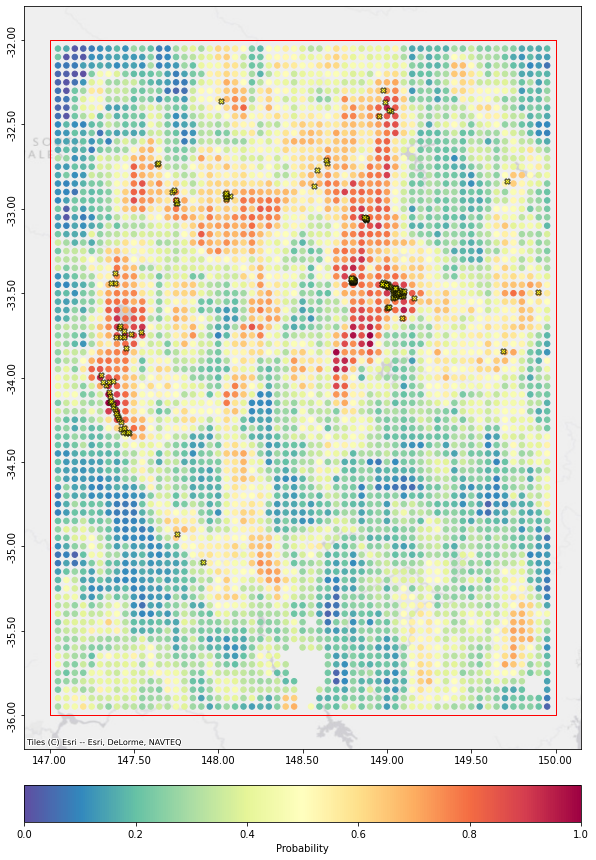

In [38]:
# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(target_probs['X'], target_probs['Y'], 30, c=target_probs['prob'], cmap='Spectral_r')
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=30, alpha=0.7)

frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

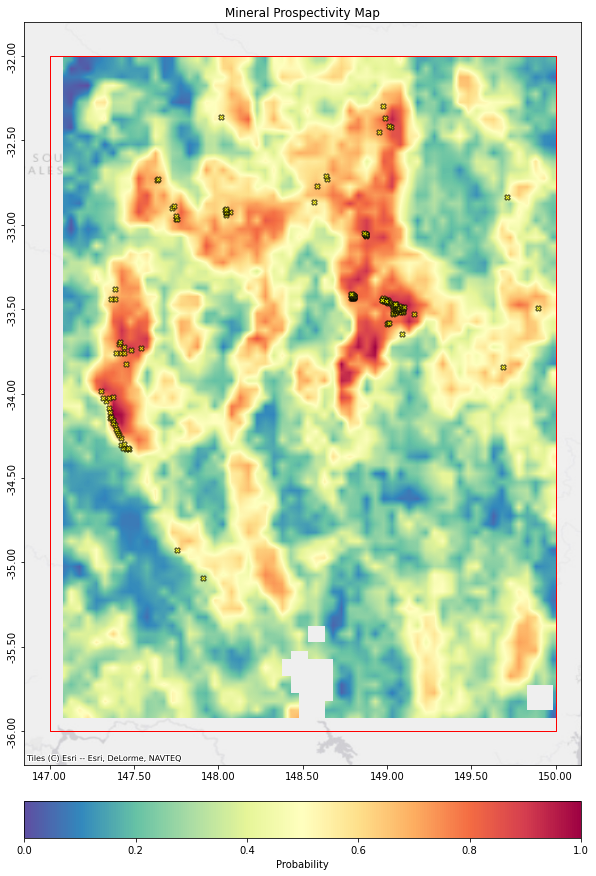

In [39]:
# create a probability map using the target points
probs_temp = []
count = 0

for mask in target_mask[:, 2]:
    if mask:
        probs_temp.append(target_probs['prob'][count])
        count += 1
    else:
        probs_temp.append(np.nan)

probs_2d = np.reshape(probs_temp, (num_y, num_x))

fig, ax = plt.subplots(figsize=(15, 15))
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=30, alpha=0.7)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.imshow(probs_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear', extent=extent_target)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Mineral Prospectivity Map')
plt.show()

In [40]:
probs_2d_ud = np.flipud(probs_2d)

# export the map to a GeoTIFF file
xmin, ymin, xmax, ymax = [min(range_x), min(range_y), max(range_x), max(range_y)]
geotransform = (xmin, 0.05, 0, ymax, 0, -0.05)
map_file = './Datasets/Outputs/probability_map_v1.1.tif'
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(map_file, num_x, num_y, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4283)
dataset.SetProjection(srs.ExportToWkt())
dataset.GetRasterBand(1).WriteArray(probs_2d_ud)
dataset.FlushCache()
dataset = None

### Select Important Features

In [41]:
features_important = []

for i in range(len(features_importance)):
    if features_importance[i][1] >= 0.02:
        features_important.append(features_importance[i][0])

Xy_train_important_file = './Datasets/Outputs/Xy_train_important.csv'
Xy_test_important_file = './Datasets/Outputs/Xy_test_important.csv'

if os.path.isfile(Xy_train_important_file) and os.path.isfile(Xy_test_important_file):
    print('The training data file already exists.')
    Xy_train_important = pd.read_csv(Xy_train_important_file, index_col=False)
    Xy_test_important = pd.read_csv(Xy_test_important_file, index_col=False)
else:
    features_important.append('sample_weight')
    features_important.append('label')
    # features_important.remove()

    Xy_train_file = './Datasets/Outputs/Xy_train.csv'
    Xy_test_file = './Datasets/Outputs/Xy_test.csv'

    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    Xy_test = pd.read_csv(Xy_test_file, index_col=False)

    Xy_train_important = Xy_train[features_important]
    Xy_test_important = Xy_test[features_important]

    Xy_train_important.to_csv('./Datasets/Outputs/Xy_train_important.csv', index=False)
    Xy_test_important.to_csv('./Datasets/Outputs/Xy_test_important.csv', index=False)

The training data file already exists.


### Create the Predictive Model

#### Hyperparameter Tuning

In [42]:
# n_estimators: number of trees in the foreset
# max_features: max number of features considered for splitting a node
# max_depth: max number of levels in each decision tree
# min_samples_split: min number of data points placed in a node before the node is split
# min_samples_leaf: min number of data points allowed in a leaf node
# bootstrap: method for sampling data points (with or without replacement)

model_important_file = './Datasets/Outputs/model_important.pkl'

if os.path.isfile(model_important_file):
    print('The model already exists!')
    # load the model
    with open(model_important_file, 'rb') as f:
        bc_best_important = pickle.load(f)
else:
    # Random Forest model structure
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    bc = BaggingPuClassifier(rf, n_jobs=-1, random_state=42)

    n_fold = 10

    Xy_train_file = f'./Datasets/Outputs/Xy_train_important.csv'
    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    features = Xy_train[Xy_train.columns[:-1]]
    labels = Xy_train[Xy_train.columns[-1]]
    X_train_, X_test_, y_train_, y_test_ = train_test_split(features, labels, train_size=0.75, random_state=42)
    
    sample_weight_train = X_train_[X_train_.columns[-1]]
    X_train_ = X_train_[X_train_.columns[:-1]]
    sample_weight_test = X_test_[X_test_.columns[-1]]
    X_test_ = X_test_[X_test_.columns[:-1]]

    search_space = {
    'base_estimator__bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
    'base_estimator__max_depth': Integer(5, 20), # values of max_depth are integers
    'base_estimator__max_features': Categorical([None, 'sqrt','log2']), 
    'base_estimator__min_samples_leaf': Integer(2, 20),
    'base_estimator__min_samples_split': Integer(2, 30),
    'base_estimator__n_estimators': Integer(10, 200),
    'max_samples': Integer(int(0.5*(len(y_train_)-sum(y_train_))), int(0.9*(len(y_train_)-sum(y_train_))))
    }

    bc_bayes_search = BayesSearchCV(bc, search_space, n_iter=50, # specify how many iterations
                                    scoring='accuracy', n_jobs=-1, cv=n_fold, verbose=1, random_state=42, return_train_score=True)
    bc_bayes_search.fit(X_train_, y_train_, sample_weight=sample_weight_train) # callback=on_step will print score after each iteration

    X_pred = bc_bayes_search.best_estimator_.predict(X_test_)
    X_pred_acc = accuracy_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_pre = precision_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_rec = recall_score(y_test_, X_pred, sample_weight=sample_weight_test)
    X_pred_f1 = f1_score(y_test_, X_pred, sample_weight=sample_weight_test)
    
    bc_best_important = bc_bayes_search.best_estimator_
    bc_best_important_acc = bc_bayes_search.best_score_
    
    print('The highest accuracy during cross validation:', bc_best_important_acc)
    print('Accuracy:', X_pred_acc)
    print('Precision:', X_pred_pre)
    print('Recall:', X_pred_rec)
    print('F1-Score:', X_pred_f1)

    # save the model
    with open(model_important_file, 'wb') as f:
        pickle.dump(bc_best_important, f)
    
    importances = []
    estimators = bc_best_important.estimators_
    importances = [estimators[j].feature_importances_.reshape(-1, 1) for j in range(len(estimators))]
    importances = np.hstack(importances)

The model already exists!


In [43]:
print(bc_best_important)

BaggingPuClassifier(base_estimator=RandomForestClassifier(max_depth=5,
                                                          max_features='sqrt',
                                                          min_samples_leaf=2,
                                                          n_estimators=10,
                                                          n_jobs=-1,
                                                          random_state=42),
                    max_samples=108, n_jobs=-1, random_state=42)


In [44]:
labels_estimated = []
for pair in bc_best_important.oob_decision_function_:
    if np.isnan(pair[0]) or pair[0] < pair[1]:
        labels_estimated.append(1)
    else:
        labels_estimated.append(0)
        
print('Number of positive samples', labels_estimated.count(1))
print('Number of negative samples', labels_estimated.count(0))

Number of positive samples 93
Number of negative samples 117


In [45]:
Xy_test_important = pd.read_csv('./Datasets/Outputs/Xy_test_important.csv', index_col=False)
X_test = Xy_test_important[Xy_test_important.columns[:-2]]
y_test = Xy_test_important[Xy_test_important.columns[-1]]
sample_weight_test = Xy_test[Xy_test.columns[-2]]
X_pred = bc_best_important.predict(X_test)
X_pred_acc = accuracy_score(y_test, X_pred, sample_weight=sample_weight_test)
print('Accuracy:', X_pred_acc)

Accuracy: 1.0


#### Feature Importance

In [46]:
features_importance_important_file = './Datasets/Outputs/features_importance_important.csv'

if os.path.isfile(features_importance_important_file):
    features_importance_important = pd.read_csv(features_importance_important_file, index_col=False).to_numpy().tolist()
else:
    importances_mean = importances.mean(axis=1)
    importances_var = importances.var(axis=1)

    features_important = [e for e in features_important if e not in ('label', 'sample_weight')]
    features_importance_important = [(feature, round(importance, 5)) for feature, importance in zip(features_important, importances_mean)]
        
    features_importance_important = sorted(features_importance_important, key=lambda x:x[1], reverse=True)
    features_importance_important_df = pd.DataFrame(features_importance_important, columns=['Feature', 'Importance'])
    features_importance_important_df['Variance'] = importances_var
    features_importance_important_df.to_csv(features_importance_important_file, index=False)

Text(0, 0.5, 'Cumulative Importance')

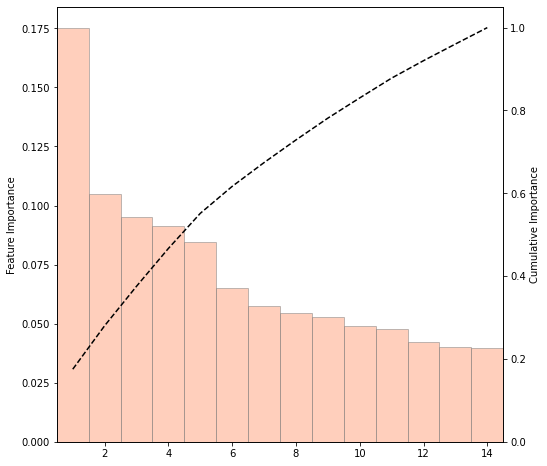

In [47]:
# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in features_importance_important]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)

x_values = list(range(len(features_importance_important)))
x_values = [x+1 for x in x_values]

fig = plt.figure(figsize=(8, 8))
ax2 = fig.add_subplot(111)
ax1 = ax2.twinx()

ax2.bar(x_values, sorted_importances, edgecolor='gray', facecolor='LightSalmon', width=1, alpha=0.5)
ax1.plot(x_values, cumulative_importances, 'k--')

plt.xticks(rotation=30)
plt.xlim(0.5, len(cumulative_importances)+0.5)

ax1.set_ylim(0, 1.05)

ax2.set_ylabel('Feature Importance')
ax1.set_ylabel('Cumulative Importance')

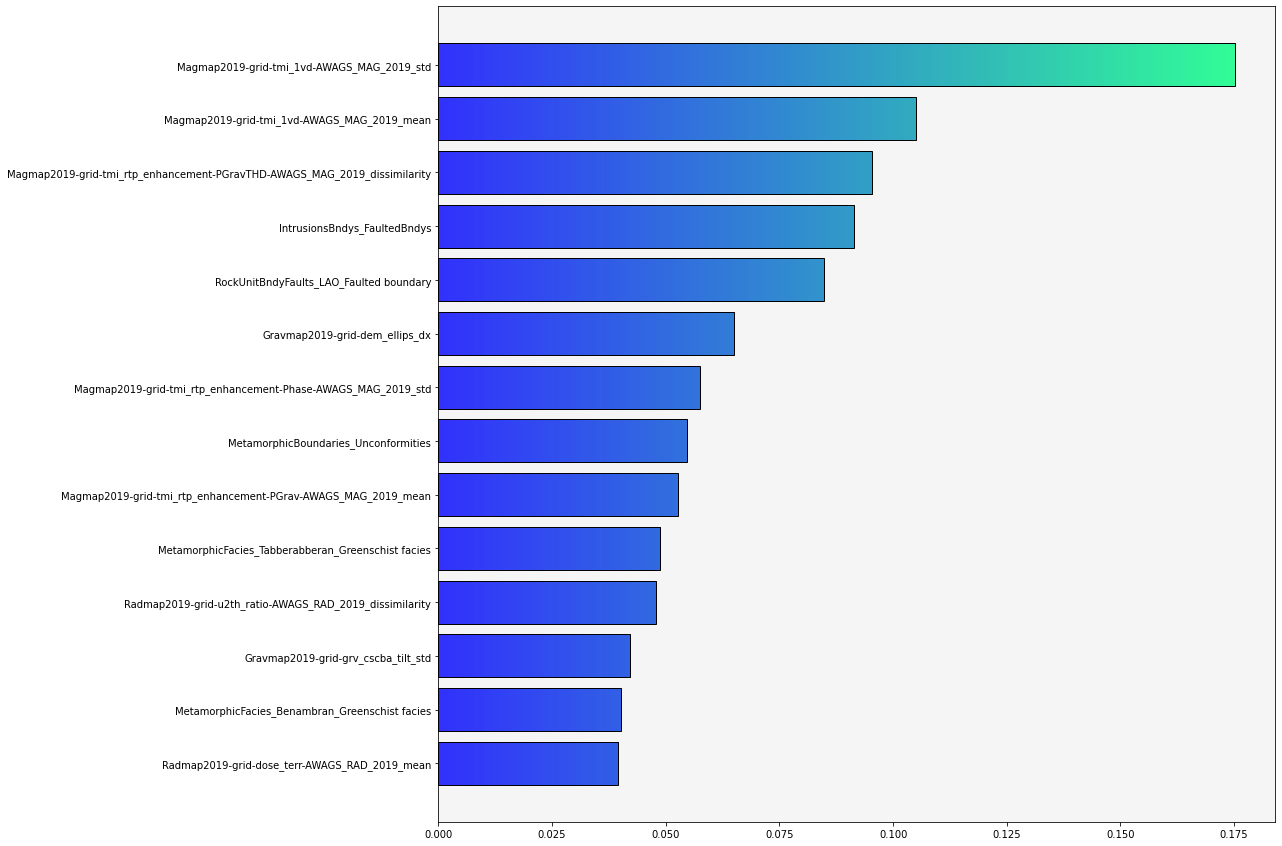

In [48]:
# print significant features above some threshold
features_importance_ = features_importance_important[:20]
features_importance_.sort(key=lambda x:x[1])
ft_imps = [x[1] for x in features_importance_]

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('whitesmoke')
bar = ax.barh(range(len(ft_imps)), ft_imps)

def gradientbars(bars, data):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        bar.set_edgecolor('black')
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        cmap = plt.get_cmap('winter')
        grad = np.atleast_2d(np.linspace(0, 1*w/max(data), 256))
        ax.imshow(grad, extent=[x, x+w, y, y+h], aspect='auto', zorder=0, norm=mpl.colors.NoNorm(vmin=0, vmax=1), cmap=cmap, alpha=0.8)
        manual_labels = [x[0] for x in features_importance_]
        ax.set_yticks(np.arange(0, len(data), 1).tolist())
        ax.set_yticklabels(manual_labels, minor=False)
    ax.axis(lim)

gradientbars(bar, ft_imps)
plt.gca().yaxis.grid(False)
plt.show()

### Calculate Probabilities

In [49]:
target_probs_important_file = './Datasets/Outputs/target_probs_important.csv'

if os.path.isfile(target_probs_important_file):
    print('The probability file already exists.')
    target_probs_important = pd.read_csv(target_probs_important_file, index_col=False)
else:
    try:
        features_important = [e for e in features_important if e not in ('label', 'sample_weight')]
        probs = bc_best_important.predict_proba(target_features[features_important])
    except:
        probs = bc_best_important.predict_proba(target_features[features_important])
    
    mm_scaler = MinMaxScaler()
    probs_scaled = mm_scaler.fit_transform(probs[:, 1].reshape(-1, 1))
    
    target_probs_important = target_coords_purged.reset_index().copy()
    target_probs_important['prob'] = probs_scaled
    target_probs_important.to_csv(target_probs_important_file, index=False)
    print(f'The probability file has been saved to {target_probs_important_file}.')

The probability file already exists.


#### Plot Prospectivity Map

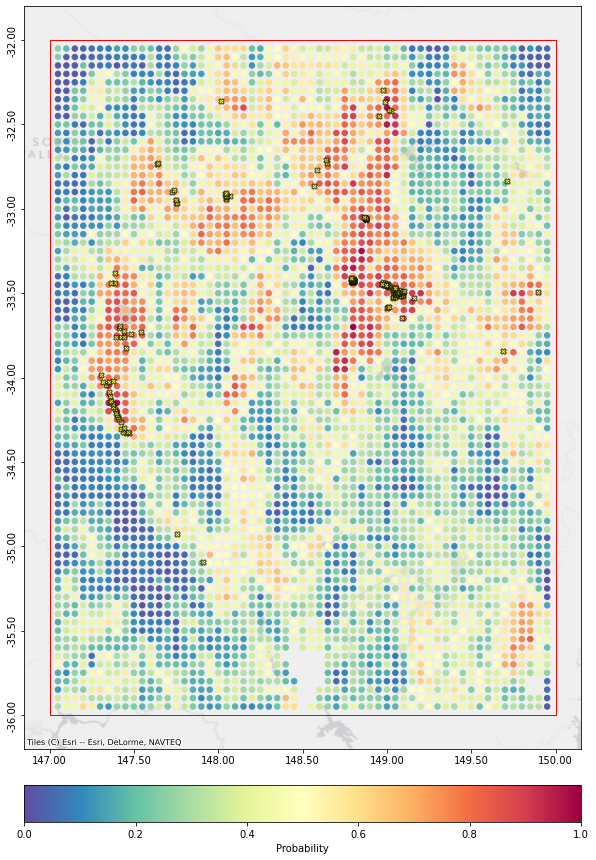

In [50]:
min_occ_clipped = min_occ.clip(frame_target)

# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(target_probs_important['X'], target_probs_important['Y'], 30, c=target_probs_important['prob'], cmap='Spectral_r')
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=30, alpha=0.7)

frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

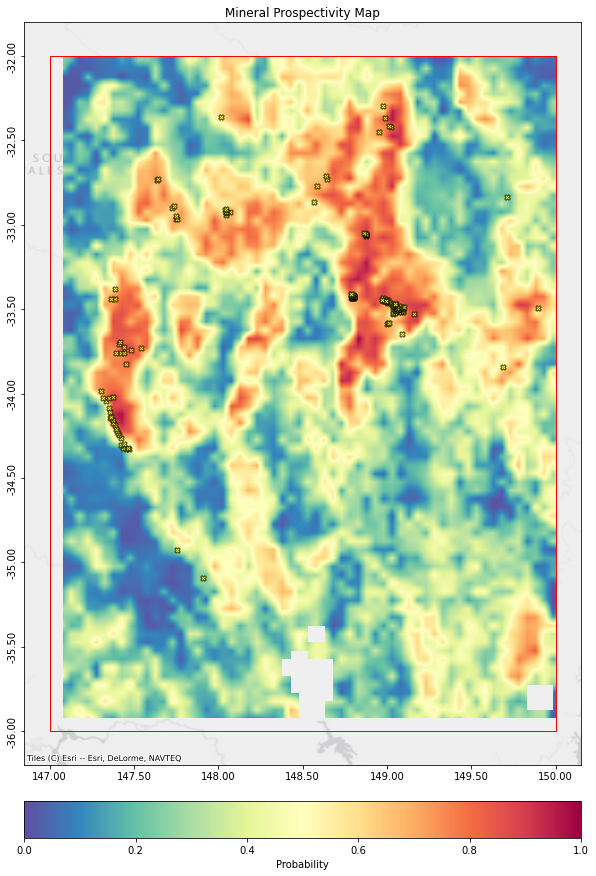

In [51]:
# create a probability map using the target points
probs_temp = []
count = 0

for mask in target_mask[:, 2]:
    if mask:
        probs_temp.append(target_probs_important['prob'][count])
        count += 1
    else:
        probs_temp.append(np.nan)

probs_2d = np.reshape(probs_temp, (num_y, num_x))

fig, ax = plt.subplots(figsize=(15, 15))
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=30, alpha=0.7)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.imshow(probs_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear', extent=extent_target)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Mineral Prospectivity Map')
plt.show()

In [52]:
probs_2d_ud = np.flipud(probs_2d)

# export the map to a GeoTIFF file
xmin, ymin, xmax, ymax = [min(range_x), min(range_y), max(range_x), max(range_y)]
geotransform = (xmin, 0.05, 0, ymax, 0, -0.05)
map_file = './Datasets/Outputs/probability_map_important_v1.1.tif'
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(map_file, num_x, num_y, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4283)
dataset.SetProjection(srs.ExportToWkt())
dataset.GetRasterBand(1).WriteArray(probs_2d_ud)
dataset.FlushCache()
dataset = None